In [246]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

from sklearn.linear_model import LogisticRegression as sklearn_LogisticRegression

from sklearn.model_selection import train_test_split

In [247]:
df = pd.read_csv('data_banknote_authentication.txt', header=None)
df.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
df = df.astype({'class': 'category'})

In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   variance  1372 non-null   float64 
 1   skewness  1372 non-null   float64 
 2   curtosis  1372 non-null   float64 
 3   entropy   1372 non-null   float64 
 4   class     1372 non-null   category
dtypes: category(1), float64(4)
memory usage: 44.5 KB


In [249]:
df.describe()

,variance,skewness,curtosis,entropy
count,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657
std,2.842763,5.869047,4.310030,2.101013
min,-7.042100,-13.773100,-5.286100,-8.548200
25%,-1.773000,-1.708200,-1.574975,-2.413450
50%,0.496180,2.319650,0.616630,-0.586650
75%,2.821475,6.814625,3.179250,0.394810
max,6.824800,12.951600,17.927400,2.449500


In [250]:
df['class'].value_counts()

0    762
1    610
Name: class, dtype: int64

In [251]:
def translate_01_to_pm1(x: int|float):
    """
    translate category values from {0, 1} to {-1, 1}
    :param x: category value
    :return: translated value
    """
    return x * 2 - 1

def adaboost_loss(y_true, y_pred):
    y_true = translate_01_to_pm1(y_true)
    y_pred = translate_01_to_pm1(y_pred)

    return tf.reduce_mean(tf.exp(-y_true * y_pred))


def bernoulli_loss(y_true, y_pred):
    y_true = translate_01_to_pm1(y_true)
    y_pred = translate_01_to_pm1(y_pred)

    return tf.reduce_mean(tf.math.log(1 + tf.exp(-y_true * y_pred)))

In [252]:
class LogisticRegression(Model):
    def __init__(self):
        super().__init__()
        self.d1 = Dense(units=1,
                        activation='sigmoid',
                        use_bias=True)

    def call(self, x):
        return self.d1(x)

In [253]:
def train_models(data, loss_funcs = ['binary_crossentropy', adaboost_loss, bernoulli_loss]):
    models = []
    hists = []
    for loss_func in loss_funcs:
        model = LogisticRegression()
        model.compile(optimizer='adam',
                      loss=loss_func,
                      metrics=['binary_accuracy'])
        hist = model.fit(train[['variance', 'skewness', 'curtosis', 'entropy']], tf.cast(train['class'], tf.float32), epochs=200,
                         validation_split=0.2, verbose=2)
        models.append(model)
        hists.append(hist)
    return hists

In [254]:
train = df.sample(frac=1, random_state=42) # shuffle all data

In [255]:
histories = train_models(data=train)

Epoch 1/200
35/35 - 1s - loss: 0.9157 - binary_accuracy: 0.5588 - val_loss: 0.9371 - val_binary_accuracy: 0.5127 - 909ms/epoch - 26ms/step
Epoch 2/200
35/35 - 0s - loss: 0.8309 - binary_accuracy: 0.5798 - val_loss: 0.8606 - val_binary_accuracy: 0.5418 - 71ms/epoch - 2ms/step
Epoch 3/200
35/35 - 0s - loss: 0.7619 - binary_accuracy: 0.6144 - val_loss: 0.7964 - val_binary_accuracy: 0.5818 - 79ms/epoch - 2ms/step
Epoch 4/200
35/35 - 0s - loss: 0.7051 - binary_accuracy: 0.6418 - val_loss: 0.7419 - val_binary_accuracy: 0.6255 - 76ms/epoch - 2ms/step
Epoch 5/200
35/35 - 0s - loss: 0.6571 - binary_accuracy: 0.6755 - val_loss: 0.6913 - val_binary_accuracy: 0.6618 - 84ms/epoch - 2ms/step
Epoch 6/200
35/35 - 0s - loss: 0.6155 - binary_accuracy: 0.6955 - val_loss: 0.6456 - val_binary_accuracy: 0.6691 - 72ms/epoch - 2ms/step
Epoch 7/200
35/35 - 0s - loss: 0.5771 - binary_accuracy: 0.7092 - val_loss: 0.6050 - val_binary_accuracy: 0.6764 - 77ms/epoch - 2ms/step
Epoch 8/200
35/35 - 0s - loss: 0.5420 -

 ### Try usual log reg as well

In [256]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [257]:
m4 = sklearn_LogisticRegression().fit(train[['variance', 'skewness', 'curtosis', 'entropy']], train['class'])
m4.score(train[['variance', 'skewness', 'curtosis', 'entropy']], train['class'])

0.99179580674567

In [258]:
acc = m4.score(test[['variance', 'skewness', 'curtosis', 'entropy']], test['class'])
acc

0.9854545454545455

### Plotting

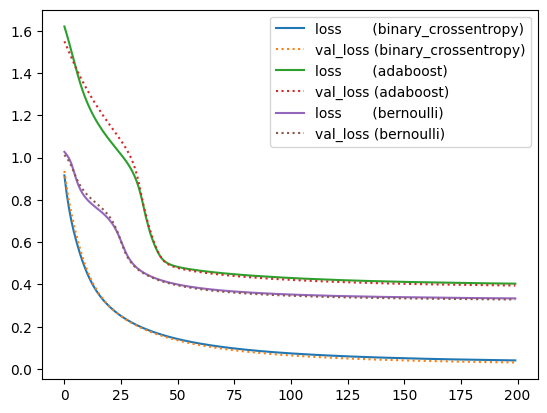

In [259]:
for hist, labels in zip(histories, ['binary_crossentropy', 'adaboost', 'bernoulli'], strict=True):
    plt.plot(hist.history['loss'], label=f'loss       ({labels})', linestyle='-')
    plt.plot(hist.history['val_loss'], label=f'val_loss ({labels})', linestyle=':')

plt.legend()

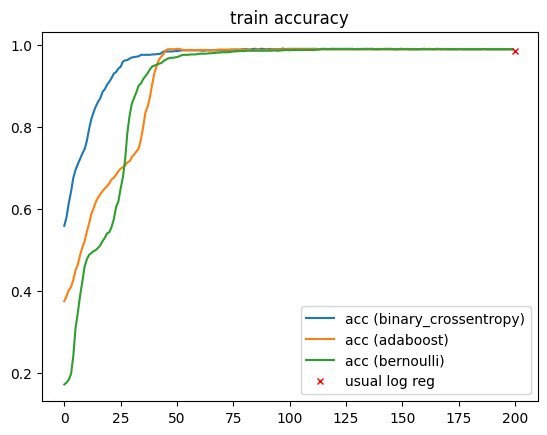

In [266]:
for hist, labels in zip(histories, ['binary_crossentropy', 'adaboost', 'bernoulli'], strict=True):
    plt.plot(hist.history['binary_accuracy'], label=f'acc ({labels})')

plt.plot(len(histories[0].history['binary_accuracy']), acc, 'rx', markersize=5, label='usual log reg')
plt.legend()
plt.title('train accuracy');

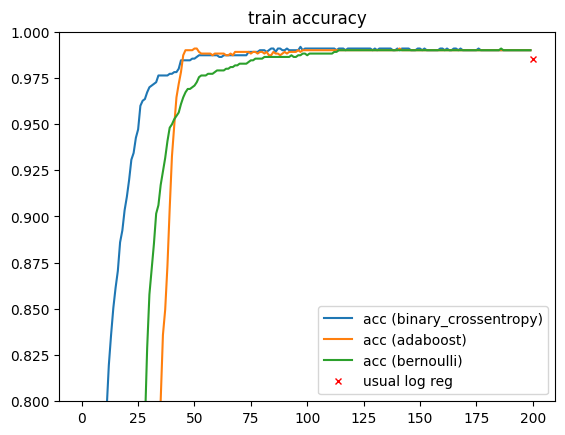

In [267]:
for hist, labels in zip(histories, ['binary_crossentropy', 'adaboost', 'bernoulli'], strict=True):
    plt.plot(hist.history['binary_accuracy'], label=f'acc ({labels})')

plt.plot(len(histories[0].history['binary_accuracy']), acc, 'rx', markersize=5, label='usual log reg')
plt.legend()
plt.ylim(0.8, 1.0);
plt.title('train accuracy');

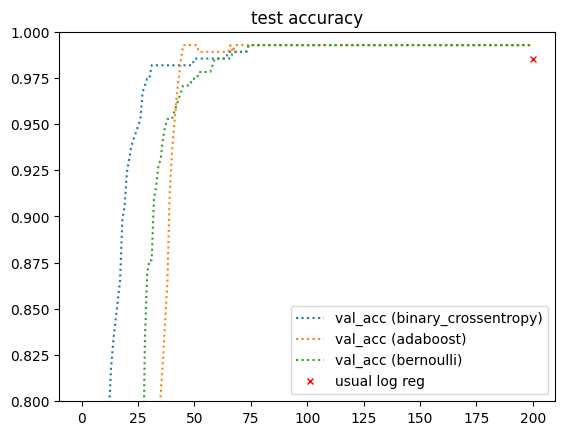

In [268]:
for hist, labels in zip(histories, ['binary_crossentropy', 'adaboost', 'bernoulli'], strict=True):
    plt.plot(hist.history['val_binary_accuracy'], label=f'val_acc ({labels})', linestyle=':')

plt.plot(len(histories[0].history['val_binary_accuracy']), acc, 'rx', markersize=5, label='usual log reg')
plt.legend()
plt.ylim(0.8, 1.0);
plt.title('test accuracy');